In [33]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv1D, AveragePooling1D, Flatten
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib as imp
import datacleaner
import datetime
imp.reload(datacleaner)
import matplotlib.pyplot as plt

from datacleaner import *

In [34]:
timesteps = 5 #number of days that make up a sequence
multivariate = 1 #number of features used by the model (using incidents to predict incidents)
multisteps = 5 #number of days to forecast – we will forecast the next 7 days
# cv_splits = 3 #time series cross validator
epochs = 50
batch_size = 7 

In [35]:
np.random.seed(1)
tf.keras.backend.clear_session()

bd = pd.read_csv(r"USAccDeaths.csv")
bd.pop("Unnamed: 0")
bd

,time,value
0,1973.000000,9007
1,1973.083333,8106
2,1973.166667,8928
3,1973.250000,9137
4,1973.333333,10017
...,...,...
67,1978.583333,9827
68,1978.666667,9110
69,1978.750000,9070
70,1978.833333,8633


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


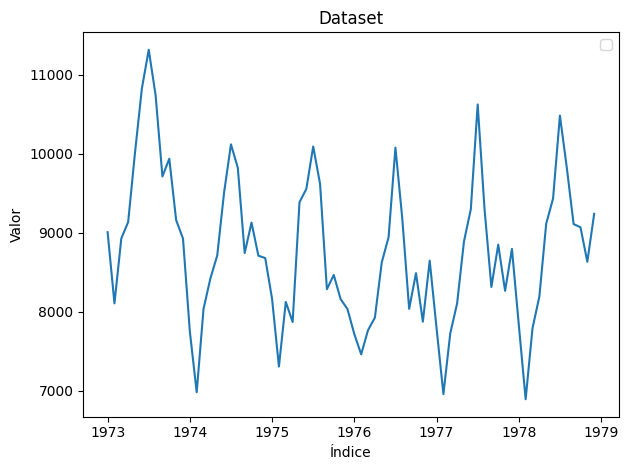

time
1973-01-01   -0.044068
1973-01-31   -0.451299
1973-03-02   -0.079774
1973-04-02    0.014689
1973-05-02    0.412429
                ...   
1978-08-01    0.326554
1978-09-01    0.002486
1978-10-01   -0.015593
1978-11-01   -0.213107
1978-12-01    0.061243
Name: value, Length: 72, dtype: float64

In [36]:
plt.title('Dataset')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.plot(bd["time"],bd["value"])
plt.legend()
plt.tight_layout()
plt.show()
from datetime import datetime, timedelta
def decimal_year_to_date(decimal_year):
    year = int(decimal_year)
    remainder = decimal_year - year
    base_date = datetime(year, 1, 1)
    days_in_year = (datetime(year + 1, 1, 1) - base_date).days
    days_to_add = int(days_in_year * remainder)
    return base_date + timedelta(days=days_to_add)

decimal_years = bd["time"]
dates = [decimal_year_to_date(decimal_year) for decimal_year in decimal_years]

formatted_dates = [date.strftime("%Y-%m-%d") for date in dates]
bd["time"]=formatted_dates
bd.index = bd['time']
bd.pop("time")
bd_original = bd
escala= MinMaxScaler(feature_range=(-1,1))
bd["value"]=escala.fit_transform(bd)
bd_normalizado = bd["value"]
bd_normalizado

In [37]:
def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [38]:
X1, y1 = df_to_X_y(bd_normalizado, timesteps)
X1.shape, y1.shape

((67, 5, 1), (67,))

In [39]:
X_train1, y_train1 = X1[:55], y1[:55]
X_val1, y_val1 = X1[55:60], y1[55:60]
X_test1, y_test1 = X1[60:], y1[60:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((55, 5, 1), (55,), (5, 5, 1), (5,), (7, 5, 1), (7,))

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [41]:
def build_model(timesteps, features, filters=16, kernel_size=5, pool_size=2):
    #using the Functional API
    inputs = Input(shape=(timesteps, features))
    print(inputs)
    #microarchitecture
    x = Conv1D(filters=filters, kernel_size=kernel_size,
    activation='relu', data_format='channels_last')(inputs)
    x = AveragePooling1D(pool_size=pool_size,
    data_format='channels_first')(x)
    #last layers
    x = Flatten()(x)
    x = Dense(filters)(x)
    outputs = Dense(1)(x)
    #the model
    cnnModel = tf.keras.Model(inputs=inputs, outputs=outputs, name='NossoCNN_model')
    # tf.keras.utils.plot_model(cnnModel, 'Kagglecnn.png', show_shapes=True)
    return cnnModel

In [42]:
model = build_model(timesteps, multivariate)
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "NossoCNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 1)]            0         
                                                                 
 conv1d (Conv1D)             (None, 1, 16)             96        
                                                                 
 average_pooling1d (AverageP  (None, 1, 8)             0         
 ooling1D)                                                       
                                                                 
 flatten (Flatten)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 16)                144       
                                      

In [43]:
cp1 = ModelCheckpoint('modelNossoCNN/model.h5', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [44]:
model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=1000, callbacks=[cp1])

Epoch 1/1000
2/2 [==============================] - 1s 154ms/step - loss: 0.2137 - root_mean_squared_error: 0.4622 - val_loss: 0.3133 - val_root_mean_squared_error: 0.5597
Epoch 2/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.2060 - root_mean_squared_error: 0.4539 - val_loss: 0.2934 - val_root_mean_squared_error: 0.5417
Epoch 3/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.2001 - root_mean_squared_error: 0.4473 - val_loss: 0.2740 - val_root_mean_squared_error: 0.5234
Epoch 4/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.1950 - root_mean_squared_error: 0.4415 - val_loss: 0.2560 - val_root_mean_squared_error: 0.5060
Epoch 5/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.1900 - root_mean_squared_error: 0.4359 - val_loss: 0.2407 - val_root_mean_squared_error: 0.4906
Epoch 6/1000
2/2 [==============================] - 0s 38ms/step - loss: 0.1863 - root_mean_squared_error: 0.4316 - val_loss: 0.2271 - val_root_

In [45]:
from tensorflow.keras.models import load_model
model = load_model('modelNossoCNN/model.h5')

In [46]:
train_predictions = model.predict(X_train1).flatten()

train_predictions_unscaled = escala.inverse_transform(train_predictions.reshape(-1, 1))
y_train1_unscaled = escala.inverse_transform(y_train1.reshape(-1, 1))

train_results = pd.DataFrame(data={'Train Predictions': train_predictions_unscaled.flatten(), 'Actuals': y_train1_unscaled.flatten()})
train_results

2/2 [==============================] - 0s 2ms/step


,Train Predictions,Actuals
0,10273.166016,10826.0
1,10754.642578,11317.0
2,10886.232422,10744.0
3,9810.017578,9713.0
4,9882.767578,9938.0
5,9213.370117,9161.0
6,8841.363281,8927.0
7,7935.358887,7750.0
8,7282.187500,6981.0
9,7883.555664,8038.0


In [47]:
val_predictions = model.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

1/1 [==============================] - 0s 16ms/step


,Val Predictions,Actuals
0,-0.512739,-0.573333
1,-0.860707,-1.000000
2,-0.552878,-0.593672
3,-0.459372,-0.412429
4,-0.016712,0.004746


In [48]:
test_predictions = model.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

1/1 [==============================] - 0s 15ms/step


,Test Predictions,Actuals
0,0.243712,0.148927
1,0.471898,0.623503
2,0.277809,0.326554
3,-0.186226,0.002486
4,0.342950,-0.015593
5,-0.128461,-0.213107
6,-0.275400,0.061243


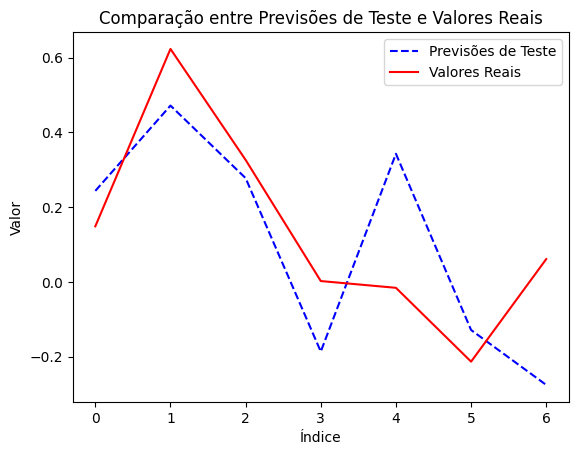

In [49]:
plt.plot(test_results['Test Predictions'], color='blue', linestyle='--', label='Previsões de Teste')
plt.plot(test_results['Actuals'], color='red', linestyle='-', label='Valores Reais')
plt.title('Comparação entre Previsões de Teste e Valores Reais')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()

In [50]:
def forecast(model, df, timesteps, multisteps, scaler):
    input_seq = df[-timesteps:].values #getting the last sequence of known value
    inp = input_seq
    predictions = list()
    for _ in range(1, multisteps+1):
        inp = inp.reshape(1, timesteps, 1)
        yhat = model.predict(inp)
        yhat_inversed = scaler.inverse_transform(yhat)
        predictions.append(yhat_inversed[0][0])
        #prepare new input to forecast the next day
        inp = np.append(inp[0], yhat)
        inp = inp[-timesteps:]
    return predictions

def plot_forecast(data, forecasts):
    plt.figure(figsize=(8,6))
    plt.plot(range(len(data)), data, color='green', label='Confirmed')
    plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
    plt.title('Number of incidents')
    plt.ylabel('Incidents')
    plt.xlabel('Days')
    plt.legend()
    plt.show()    

In [51]:
forecasts = forecast(model, bd, timesteps, multisteps=multisteps, scaler=escala)
forecasts

1/1 [==============================] - 0s 17ms/step


[8475.0205, 7646.619, 7405.916, 7527.648, 8424.5]

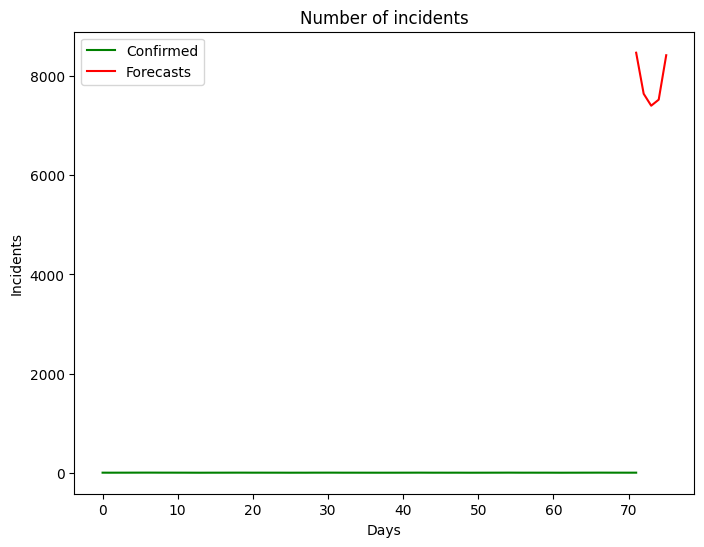

In [52]:
plot_forecast(bd, forecasts)